# **Sentiment analysis of youtube comments**

## **Outline**

In this work, simple natural language processing (nlp) techniques are used to derive a model for sentiment analysis of youtube comments. A Kaggle dataset of youtube comments is used to train and validate the model. The dataset contains two columns, the comment text and the sentiment, classified as "positive", "negative" or "neutral". The neutral instances are removed from the analysis and only positive and negative sentiments are considered.

## **Importing libraries**

In [1]:
import pandas as pd
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pickle

## **Functions**

In [2]:
# in this class the text cleaning procedures are defined
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # no hyperparameters needed for this step

    def fit(self, X, y=None):
        return self  # no fitting needed

    def transform(self, X):
        return X.apply(self.text_cleaning)  # apply text cleaning function to each row

    def text_cleaning(self, text):
        doc = nlp(text)
        cleaned_text = ' '.join([token.lemma_ for token in doc])  # lemmatization
        cleaned_text = re.sub(r'([^\s\w]|_)+', ' ', cleaned_text)  # keeps only letters and numbers
        return re.sub(r'\s+', ' ', cleaned_text).strip()  # removes extra spaces

In [3]:
# computes evaluation metrics
def creates_metrics_table(df_pred_actual, models):    
    accuracy, f1, auc = [], [], []
    
    for m in models.items():
        
        accuracy.append(accuracy_score(df_pred_actual['actual'], df_pred_actual[m[0]]))
        f1.append(f1_score(df_pred_actual['actual'], df_pred_actual[m[0]]))
        auc.append(roc_auc_score(df_pred_actual['actual'], df_pred_actual[m[0] + '_prob']))
        
    return pd.DataFrame({'Accuracy' : accuracy, 'F1-Score' : f1, 'AUC' : auc}, index=models.keys())

In [5]:
# colors words in a wordcloud according to the positive or negative effect
def make_color_func(df):
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if df.loc[df['Feature'] == word, 'Coefficient'].values[0] > 0:
            return 'blue'  # positive words in blue
        else:
            return 'red'  # negative words in red
    return color_func

In [6]:
# builds the wordcloud
def builds_wordcloud(pipeline):
    # gets the vectorizer and classifier from the pipeline
    vectorizer = pipeline.named_steps['vectorizer']
    classifier = pipeline.named_steps['classifier']
    
    # get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # gets coefficients from the classifier
    coefficients = classifier.coef_[0]  
    
    # creates a dataframe containing words and their coefficients in the logistic model
    import pandas as pd
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    word_coeff = dict(zip(coef_df['Feature'], abs(coef_df['Coefficient'])))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate_from_frequencies(word_coeff)

    # creates the color function dynamically
    color_func_with_df = make_color_func(coef_df)

    # applies the custom coloring
    wordcloud.recolor(color_func=color_func_with_df)
    
    # displays the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [7]:
# defines the pipeline
def pipeline_function(model):
    return Pipeline([
        ('text_cleaner', TextCleaner()),  # custom text cleaning transformer
        ('vectorizer', TfidfVectorizer(max_features=500)),  # convert text to numerical features using tf-idf
        ('classifier', model)  # classifier model
    ])

## **Loading the dataset** 

In [8]:
# loads the dataset 
df = pd.read_csv('YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [9]:
# checks the size of the different classes
df.Sentiment.value_counts()

Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64

Checking for missing data

In [10]:
# checks missing data
print('Missing data:')
print(df.isna().sum())

Dados faltantes:
Comment      44
Sentiment     0
dtype: int64


In [11]:
# removes rows without comments 
df = df.loc[~df.Comment.isna()]

In [12]:
# removes neutral comments
df = df.loc[~(df.Sentiment == 'neutral')]

# transforms target to numeric
df['Sentiment'] = df['Sentiment'].map({'positive' : 1, 'negative' : 0})

## **Training machine learning models**

### Train-test split

In [13]:
# divides text and target
X, y = df['Comment'], df['Sentiment']

# splits data into train and test partitions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Fitting models

In [14]:
# list of models
models = {'logreg' : LogisticRegression(), 'xgboost' : XGBClassifier()}

In [15]:
# initializes de prediction versus actual dataframe
pred_vs_real = pd.DataFrame({'actual' : y_test})
pipelines_list = []
# fits models
for m in models.items():
    pipe  = pipeline_function(m[1])
    pipe.fit(X_train, y_train)

    predictions = pipe.predict(X_test) 
    probabilities = pipe.predict_proba(X_test)

    pipelines_list.append(pipe)
    
    pred_vs_real[m[0]] = predictions
    pred_vs_real[m[0] + '_prob'] = probabilities[:, 1]

In [16]:
pred_vs_real.iloc[:20]

,actual,logreg,logreg_prob,xgboost,xgboost_prob
8205,1,1,0.996696,1,0.998051
11293,1,1,0.985100,1,0.937425
12284,0,0,0.129586,0,0.110472
17858,1,1,0.966698,1,0.982721
11456,1,1,0.569850,1,0.724998
12696,1,1,0.871747,1,0.891624
1275,1,1,0.875856,1,0.912723
10308,0,0,0.415202,0,0.238692
11068,1,1,0.687667,1,0.847725
8509,1,1,0.984706,1,0.906123


### Computing evaluation metrics

In [17]:
# computes evaluation metrics
metrics = creates_metrics_table(pred_vs_real, models)
metrics

,Accuracy,F1-Score,AUC
logreg,0.867904,0.924517,0.895292
xgboost,0.870815,0.925530,0.893507


### Word cloud of terms importance

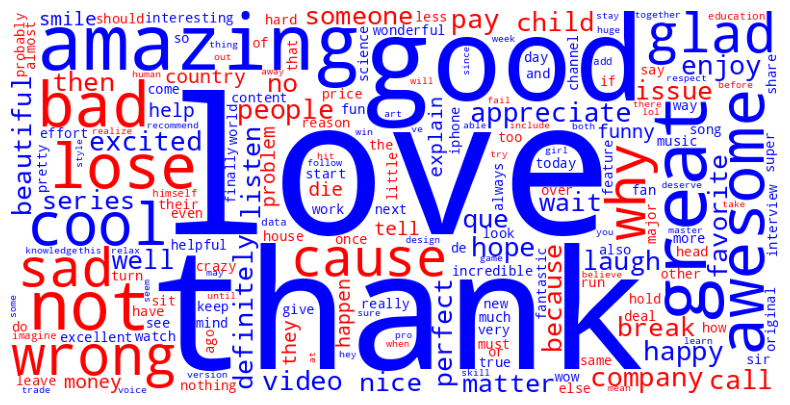

In [18]:
# builds the word cloud
builds_wordcloud(pipelines_list[0])

### Saving the model

In [21]:
# saves the model in a pickle file
pickle.dump(pipelines_list[1], open("sentiment-analysis-logreg.pkl", "wb"))